In [1]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

from lcapt.analysis import make_feature_grid
from lcapt.lca import LCAConv2D
from lcapt.metric import compute_l1_sparsity, compute_l2_error

In [2]:
BATCH_SIZE = 64
EPOCHS = 25
FEATURES = 784 * 2  # number of dictionary features to learn
KERNEL_SIZE = 28  # height and width of each feature
LAMBDA = 0.75  # LCA threshold
LCA_ITERS = 800
PRINT_FREQ = 100
STRIDE = KERNEL_SIZE  # convolutional stride
TAU = 100 # LCA time constant

In [3]:
dset = MNIST('./data', download=True, transform=ToTensor())
dataloader = DataLoader(dset, BATCH_SIZE, shuffle=True, num_workers=4)

In [4]:
lca = LCAConv2D(
    out_neurons=FEATURES,
    in_neurons=1,
    result_dir='./mnist_dictionary_learning',
    kernel_size=KERNEL_SIZE,
    stride=STRIDE,
    lambda_=LAMBDA,
    tau=TAU,
    track_metrics=False,
    return_vars=['inputs', 'acts', 'recons', 'recon_errors'],
    pad='valid',
    eta=1e-3
)
if torch.cuda.is_available():
    lca = torch.nn.DataParallel(lca).cuda()

In [ ]:
for epoch in range(EPOCHS):
    for batch_num, (images, _) in enumerate(dataloader):
        images = images.cuda()
        inputs, code, recon, recon_error = lca(images)
        lca.module.update_weights(code, recon_error)
        if batch_num % PRINT_FREQ == 0:
            l1_sparsity = compute_l1_sparsity(code, lca.module.lambda_).item()
            l2_recon_error = compute_l2_error(inputs, recon).item()
            total_energy = l2_recon_error + l1_sparsity
            print(f'L2 Recon Error: {round(l2_recon_error, 2)}; ',
                  f'L1 Sparsity: {round(l1_sparsity, 2)}; ',
                  f'Total Energy: {round(total_energy, 2)}')
    torch.save(lca, 'lca_mnist.pt')

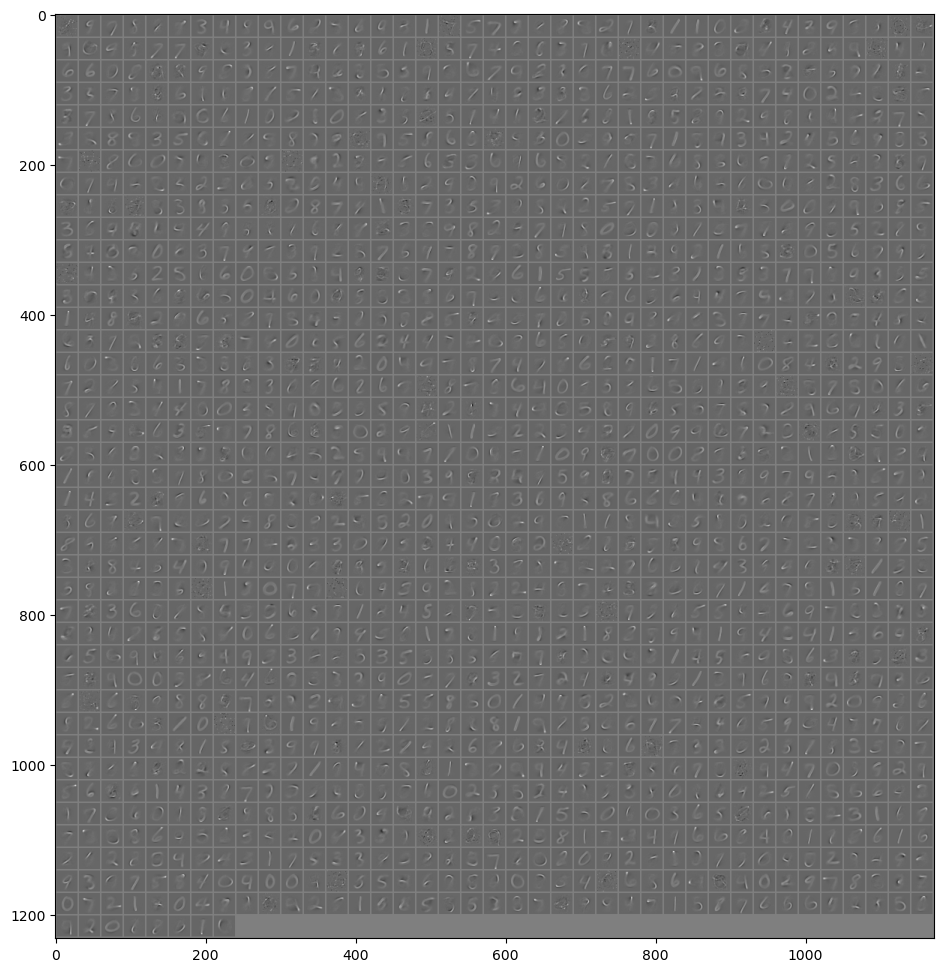

In [10]:
weight_grid = make_feature_grid(lca.module.get_weights())
fig = plt.figure(figsize=(12, 12))
plt.imshow(weight_grid.cpu().numpy())

Text(0.5, 1.0, 'Input - Reconstruction')

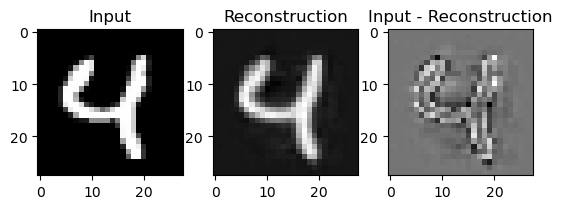

In [12]:
fig, ax = plt.subplots(1, 3)
inputs = inputs[0].cpu().numpy().transpose(1, 2, 0)
recon = recon[0].cpu().numpy().transpose(1, 2, 0)
recon_error = recon_error[0].cpu().numpy().transpose(1, 2, 0)
recon = (recon - recon.min()) / (recon.max() - recon.min())
inputs = (inputs - inputs.min()) / (inputs.max() - inputs.min())
recon_error = (recon_error - recon_error.min()) / (recon_error.max() - recon_error.min())
img1 = ax[0].imshow(inputs, cmap='gray')
img2 = ax[1].imshow(recon, cmap='gray')
img3 = ax[2].imshow(recon_error, cmap='gray')
ax[0].set_title('Input')
ax[1].set_title('Reconstruction')
ax[2].set_title('Input - Reconstruction')